Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


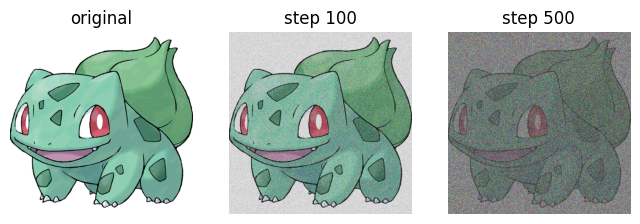

In [1]:
from diffusers import DDPMScheduler

checkpoint = 'CompVis/stable-diffusion-v1-4'

scheduler = DDPMScheduler.from_pretrained(checkpoint, subfolder='scheduler')

#测试scheduler
def test_scheduler():
    from matplotlib import pyplot as plt
    %matplotlib inline
    import PIL.Image
    import torch
    import numpy as np

    def show(image, idx, title):
        plt.subplot(1, 3, idx)
        plt.imshow(image)
        plt.axis('off')
        plt.title(title)

    plt.figure(figsize=[8, 3])

    #加载测试图片
    image = PIL.Image.open('测试图片.jpeg')
    image = torch.FloatTensor(np.array(image)) / 255.0

    #打印原始图片
    show(image, 1, 'original')

    #随机噪声
    noise = torch.randn(image.shape)

    #混合到100步
    image_noise = scheduler.add_noise(image, noise, torch.LongTensor([100]))
    show(image_noise, 2, 'step 100')

    #混合到500步
    image_noise = scheduler.add_noise(image, noise, torch.LongTensor([500]))
    show(image_noise, 3, 'step 500')

    plt.show()


test_scheduler()

In [2]:
from transformers import CLIPTextModel
import torch

#加载3个模型
encoder = CLIPTextModel.from_pretrained(checkpoint, subfolder='text_encoder')


#测试encoder,可以简单地理解成文字embed层
def test_encoder():
    input_ids = torch.LongTensor([[
        49406, 320, 1746, 537, 1449, 14115, 593, 1237, 3095, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407
    ]])
    
    out_encoder = encoder(input_ids)[0]

    print(out_encoder, out_encoder.dtype, out_encoder.shape)


test_encoder()

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.4252,  0.3786,  1.0890,  ...,  0.5633,  0.1531,  1.6417],
         ...,
         [ 0.3053,  0.4566,  1.7745,  ..., -0.5398, -0.7917,  0.7100],
         [ 0.2753,  0.4111,  1.7659,  ..., -0.5137, -0.7963,  0.6700],
         [ 0.3266,  0.4478,  1.8617,  ..., -0.5920, -0.7630,  0.6852]]],
       grad_fn=<NativeLayerNormBackward0>) torch.float32 torch.Size([1, 77, 768])


In [3]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained(checkpoint, subfolder='vae')


#测试vae,它的计算结果是一张图征图的mena和std
def test_vae():
    pixel_values = torch.randn(1, 3, 512, 512).clip(min=-1.0, max=1.0)

    #根据数据计算出正态分布的mean和std
    out_vae = vae.encode(pixel_values).latent_dist

    #[1, 4, 64, 64], [1, 4, 64, 64]
    print(out_vae.mean.shape, out_vae.std.shape)

    #根据mean和std采样
    #等价写法:sample = out_vae.mean + out_vae.std * torch.randn(1, 4, 64, 64)
    #[1, 4, 64, 64]
    out_vae = out_vae.sample()

    #乘以系数,0.18215 = vae.config.scaling_factor
    out_vae = out_vae * 0.18215

    #[1, 4, 64, 64]
    print(out_vae.mean(), out_vae.std(), out_vae.dtype, out_vae.shape)


test_vae()

torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64])
tensor(-0.2885, grad_fn=<MeanBackward0>) tensor(0.7106, grad_fn=<StdBackward0>) torch.float32 torch.Size([1, 4, 64, 64])


In [4]:
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(checkpoint, subfolder='unet')

#测试unet,可以简单地理解成VAE,不过是带有跨层连接的
def test_unet():
    #虚拟encoder和vae的输出
    out_encoder = torch.randn(1, 77, 768)
    out_vae = torch.randn(1, 4, 64, 64)

    #随机噪声,也就是unet计算的目标
    noise = torch.randn_like(out_vae)

    #这个数字实际应该是随机得到的,值域0-1000
    noise_step = torch.LongTensor([500])

    #往vae输出的特征图中添加噪声
    out_vae_noise = scheduler.add_noise(out_vae, noise, noise_step)

    #unet的目标是把添加的噪声计算出来
    out_unet = unet(out_vae_noise, noise_step, out_encoder).sample

    print(out_unet, out_unet.dtype, out_unet.shape)


test_unet()

tensor([[[[ 1.0642, -0.8302,  0.0827,  ...,  0.2089,  1.5960, -1.5913],
          [-0.7829, -0.1465,  1.0607,  ..., -0.4575,  1.3467,  1.8900],
          [-0.5092, -0.4552, -0.3525,  ..., -1.9699, -0.4021,  0.1327],
          ...,
          [ 1.1197,  0.8554,  0.1123,  ...,  0.7239,  0.4699, -1.2913],
          [ 0.4019, -0.1141, -0.0105,  ..., -0.4707,  0.9638, -1.0623],
          [-0.1334,  0.0951,  0.4682,  ..., -1.0470, -0.3296,  0.6019]],

         [[ 0.1582,  0.7066, -1.1967,  ...,  0.1289,  0.0024, -1.1636],
          [-0.4941,  0.9606, -0.1465,  ..., -0.1156, -0.1169, -0.7351],
          [-0.3523, -0.6632, -1.9117,  ...,  0.4305, -0.0194, -0.5949],
          ...,
          [-0.6379,  0.4924,  0.3776,  ..., -0.2490,  0.0419, -0.9089],
          [ 1.2206,  0.3752, -0.6222,  ..., -0.3539, -1.5609,  0.1927],
          [ 0.0754, -0.6664,  1.1142,  ...,  0.9836, -0.2045, -0.4533]],

         [[-0.7519,  0.8494,  0.6017,  ...,  0.3118,  1.1055,  1.0538],
          [ 0.2285, -0.4305,  

In [5]:
#这个类的代码是抄的 from diffusers.training_utils import EMAModel
class EMAModel:

    def __init__(self, parameters):
        #克隆一份参数
        self.shadow_params = [p.clone().detach() for p in list(parameters)]
        #记录step的次数
        self.optimization_step = 0

    #计算权重,值域在0-1之间,随着step的增长而逐渐增长
    def get_decay(self):
        step = self.optimization_step - 1

        if step == 0:
            return 0.0

        #一开始是接近1/10,随着step的增长,越来越接近1
        cur_decay_value = (1 + step) / (10 + step)

        #限定值在0-1之间
        cur_decay_value = min(cur_decay_value, 0.999)
        cur_decay_value = max(cur_decay_value, 0.0)

        return cur_decay_value

    @torch.no_grad()
    def step(self, parameters):
        #增长step数
        self.optimization_step += 1

        #计算更新比例,这个数字是从0开始逐渐增长到1
        decay = self.get_decay()

        #更新比例取反,一开始更新的多,以后更新的逐渐减少
        one_minus_decay = 1 - decay

        #按比例更新
        for s_param, param in zip(self.shadow_params, list(parameters)):

            #先计算两份参数的差,再从参数中按比例减去差
            #这就相当于按比例更新了,a-(a-b) = a-a+b = b
            s_param.sub_(one_minus_decay * (s_param - param))

        torch.cuda.empty_cache()

    #复制参数出去
    def copy_to(self, parameters):
        for s_param, param in zip(self.shadow_params, list(parameters)):
            param.data.copy_(s_param.to(param.device).data)

    #设置计算设备
    def to(self, device):
        self.shadow_params = [p.to(device) for p in self.shadow_params]


ema = EMAModel(unet.parameters())

ema

In [ ]:
#使用ema训练的样例代码
def sample_ema():
    #设置计算设备
    unet.to('cuda')
    ema.to('cuda')

    #循环
    for epoch in range(100):
        #unet训练一步
        optimizer.step()

        #ema更新参数
        ema.step(unet.parameters())

    #ema中的参数复制到unet中
    ema.copy_to(unet.parameters())